<a href="https://colab.research.google.com/github/ahoydave/ipynb_fiddles/blob/main/Neuronal_Dynamics_experiments_hopfield_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuronal Dynamics experiments: Hopfield model for memory

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import functools as ft

We're going to build a network of simplified neurons that is able to recover patterns that have been encoded in the network's connections.

Let's start by first building up the model of interactions.

Take $N$ neurons which take on one of two states. If a particular neuron, $i$, is "on" then $S_i=1$ and, if "off", then $S_i=-1$.

We model the evolution of the network in discrete timesteps. Neuron $i$ is connected to another neuron, $j$, with weight $w_{ij}$ and so the input to neuron $i$ at time $t$ is given by,
$$
h(t) = \sum_{j=1}^{N}w_{ij}S_i(t)
$$
The new state of each neuron is then an "activation" function applied to the input total. The function just keeps the sign of the input value.
$$
sgn[h]=
\begin{cases}
1 & \text{if} & h \geq 0 \\
-1 & \text{if} & h < 0
\end{cases}
$$
The update rule is therefore the sum of the weighted influence of other neurons, clamped to one of the values $\{-1, 1\}$
$$
S_i(t+1) = sgn[\sum_{j=1} ^N w_{ij}S_j(t)]
$$
Note that there is weight between $i$ and itself which probably isn't all that biologically plausible but it makes things easier. We can experiment with taking that away later maybe.

We now need to decide how to set the weights. We want to give the neurons initial values and then allow the system to evolve. The idea is that the network settles down in one of the "memorised" patterns.

If we consider just 9 neurons with a single memorised pattern:

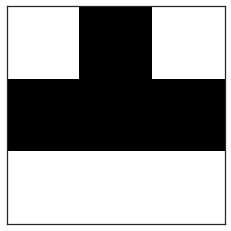

In [24]:
pattern1 = np.array([-1, 1, -1, 1, 1, 1, -1, -1, -1]).reshape(1,9)
fig, ax = plt.subplots(1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.imshow(pattern1.reshape(3, 3));

If the neurons start out matching the pattern then the weights should keep the neurons in this state. If this doesn't work then we're lost completely.

To do this, consider the top left neuron (position `0`). It should have a weight of `1` with itself, `-1` with the neuron on it's right, `1` with the next and so on giving us
```
[1, -1, 1, -1, -1, -1, 1, 1, 1]
```
This is conveniently

In [25]:
pattern1[0,0] * pattern1

array([[ 1, -1,  1, -1, -1, -1,  1,  1,  1]])

In fact, multiplying each element by the whole vector is just the matrix multiplication. Note that the resulting weight matrix is always symmetrical.

In [26]:
pattern1_weights = np.matmul(pattern1.T, pattern1)
print(pattern1_weights)
(pattern1_weights == pattern1_weights.T).all()

[[ 1 -1  1 -1 -1 -1  1  1  1]
 [-1  1 -1  1  1  1 -1 -1 -1]
 [ 1 -1  1 -1 -1 -1  1  1  1]
 [-1  1 -1  1  1  1 -1 -1 -1]
 [-1  1 -1  1  1  1 -1 -1 -1]
 [-1  1 -1  1  1  1 -1 -1 -1]
 [ 1 -1  1 -1 -1 -1  1  1  1]
 [ 1 -1  1 -1 -1 -1  1  1  1]
 [ 1 -1  1 -1 -1 -1  1  1  1]]


True

Updating the state then becomes a matrix multiplication

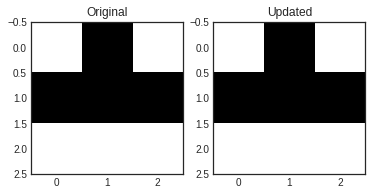

In [28]:
def sgn(x):
  if (x > 0):
    return 1
  return -1

vec_sgn = np.vectorize(sgn)

pattern1_updated = vec_sgn(np.matmul(pattern1, pattern1_weights))

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Original")
axs[0].imshow(pattern1.reshape(3, 3))
axs[1].set_title("Updated")
axs[1].imshow(pattern1_updated.reshape(3, 3));

Now the question is what happens when the initial state doesn't match the pattern? Lets try something with a few changes.

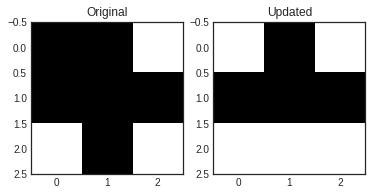

In [29]:
s1 = np.array([1, 1, 0, 1, 1, 1, 0, 1, 0])
s1_updated = vec_sgn(np.matmul(pattern1, pattern1_weights))

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Original")
axs[0].imshow(s1.reshape(3, 3))
axs[1].set_title("Updated")
axs[1].imshow(s1_updated.reshape(3, 3));

Woohoo!

But what about more patterns? It turns out that you can just add the weights of multiple patterns. Given some assumptions about the patterns being relatively unrelated (in a hand wavy kinda way), it should just work.

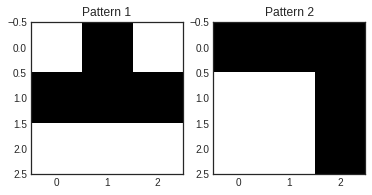

In [30]:
pattern2 = np.array([1, 1, 1, -1, -1, 1, -1, -1, 1]).reshape(1, 9)

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Pattern 1")
axs[0].imshow(pattern1.reshape(3, 3))
axs[1].set_title("Pattern 2")
axs[1].imshow(pattern2.reshape(3, 3));

pattern2_weights = np.matmul(pattern2.T, pattern2)
combo_weights = pattern1_weights + pattern2_weights

Let's try a few random inputs then and see what happens. We run the updates until the states stop changing.

found a difference


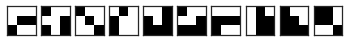

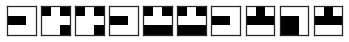

In [36]:
num_states = 10

states = vec_sgn([np.random.rand(1, 9) * 2 - 1 for _ in range(num_states)])

stationary = False

while not stationary:
  fig, axs = plt.subplots(1, num_states)
  for state, ax in zip(states, axs):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(state.reshape(3,3))

  updated_states = [vec_sgn(np.matmul(state, combo_weights)) for state in states]
  combo_weights2[0,0]
  stationary = True
  for states1, states2 in zip(states, updated_states):
    if not (states1 == states2).all():
      stationary = False
      break
  
  states = updated_states

Hmmmm ok so now it is finding some weird combination of patterns sometimes. It might be that we need more neurons to hold multiple patterns. Let's scale this baby up.

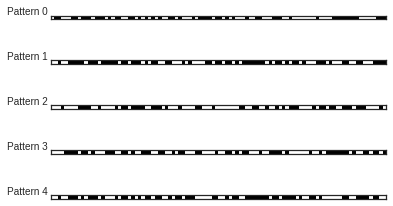

In [64]:
num_neurons = 100
num_patterns = 5

patterns = vec_sgn([np.random.rand(1, num_neurons) * 2 - 1 for _ in range(num_patterns)])
fig, axs = plt.subplots(num_patterns)

for i, (pattern, ax) in enumerate(zip(patterns, axs)):
  ax.set_ylabel(f"Pattern {i}", rotation=0, labelpad=20)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(pattern)

In [65]:
pattern_weights = map(lambda p: np.matmul(p.T, p), patterns)
combo_weights2 = ft.reduce(lambda a, b: a + b, pattern_weights)

Matches pattern 3


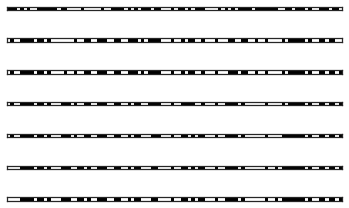

In [78]:
state_progression = [vec_sgn(np.random.rand(1, num_neurons) * 2 - 1)]

stationary = False

while not stationary:
  new_state = vec_sgn(np.matmul(state_progression[-1], combo_weights2))
  state_progression.append(new_state)
  stationary = (state_progression[-1] == state_progression[-2]).all()

fig, axs = plt.subplots(len(state_progression))
for state, ax in zip(state_progression, axs):
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(state)

for i, pattern in enumerate(patterns):
  if (state_progression[-1] == pattern).all():
    print("Matches pattern {0}".format(i))

Ok so that kind of works.

## Further ideas

* add a distance metric
* sparse connections
* probabilistic updates